In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFR
RFR=RFR()
from sklearn.linear_model import LinearRegression as LR
LR=LR()
from sklearn import metrics
import matplotlib.pyplot as plt
l=4 # Comprimento do teste em meses

i_0=pd.read_csv('~/git/BD/temp/imp_fert_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])
i_0=i_0[i_0.SG_UF_NCM=='BA']
i_0['date']=pd.to_datetime(i_0.CO_ANO.astype(str)+'/'+i_0.CO_MES.astype(str)+'/1')
i_0=i_0.groupby(by=['date','CO_ANO','CO_MES'])['KG_LIQUIDO'].sum().reset_index().sort_values('date')
i_0=i_0.sort_values('date')

In [2]:
i_0.groupby(by=['CO_ANO']).CO_MES.count().reset_index()

,CO_ANO,CO_MES
0,1997,10
1,1998,12
2,1999,10
3,2000,12
4,2001,10
5,2002,11
6,2003,11
7,2004,12
8,2005,11
9,2006,12


In [3]:
i_0=i_0[i_0.CO_ANO>2008]

In [4]:
i_0['kg_acm']=i_0.KG_LIQUIDO.rolling(12).sum()

In [5]:
i_0=i_0.dropna()

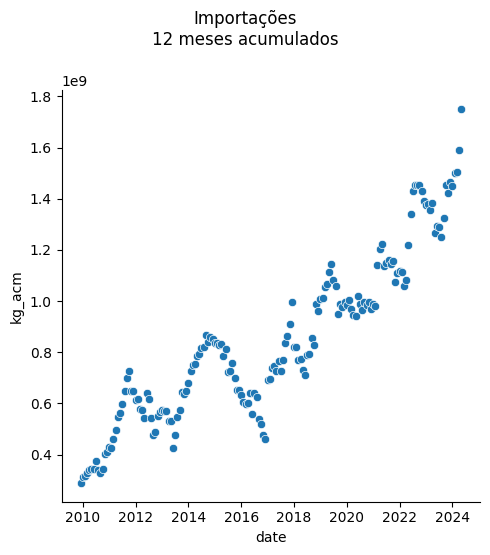

In [6]:
sns.relplot(data=i_0,x='date',y='kg_acm').fig.suptitle('Importações\n12 meses acumulados',y=1.1)
plt.show()

In [7]:
def predict(i, regressor,l):
    
    pred=pd.DataFrame()
    
    while (i.date.max()-i.date.min()).days/30>=l:

        
        # Limita comprimento em anos
        j=i[i.date>i.date.max()-pd.DateOffset(months=l)]

        
        # Tipifica a data para processamento ML
        j.date=j.date.astype(int)

        # Limita categorias do traino as categorias presentes no teste
        #cat_pred=j[j.date==j.date.max()].CO_MES.values[0]
        #j=j[j.CO_MES==cat_pred]
        
        # Codifica categorias
        #j.CO_MES=j.CO_MES.astype('category')
        #j=pd.get_dummies(j,prefix_sep='~')
    
        # Identifica as variáveis
        train=j[j.date<j.date.max()]
        test=j[j.date==j.date.max()]
        X_train=train[['date']]
        y_train=train['kg_acm']
        X_test=test[['date']]
        y_test=test['kg_acm']

        # Prediz
        regressor.fit(X_train,y_train)
        q=X_test.assign(kg_pred=regressor.predict(X_test)).assign(kg_acm=y_test)
        pred=pd.concat([q,pred])
        i=i[i.date<i.date.max()]
    
    return pred

In [20]:
i=i_0.copy()

In [23]:
pred=predict(i,LR,3)

In [24]:
round(metrics.r2_score(pred['kg_acm'],pred.kg_pred),2)

0.95

In [28]:
i=i_0.copy()

In [29]:
pred=predict(i,RFR,3)

In [30]:
round(metrics.r2_score(pred['kg_acm'],pred.kg_pred),2)

0.97